In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os


In [3]:
#dataset
class BMIDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform = None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.annotations)
    def __getitem__(self,idx
                    ):
        img_path = self.annotations.iloc[idx, 5]
        image = Image.open(img_path).convert("RGB")
        bmi_label = float(self.annotations.iloc[idx, 4])

        if self.transform:
            image = self.transform(image)

        return (image, bmi_label)
    

In [4]:
resize = 224

In [5]:
transform = transforms.Compose([
    transforms.Resize((resize, resize)),  # Chọn kích thước ảnh sau khi augment
    transforms.ToTensor(),  # Chuyển ảnh sang tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Chuẩn hóa tensor
])

In [6]:
transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)

In [7]:
class BMIModel(nn.Module):
    def __init__(self):
        super(BMIModel,self).__init__()
        self.conv1 = nn.Conv2d(3,6, 3) #224x224
        self.relu1 = nn.ReLU()
        self.batch1 = nn.BatchNorm2d(6)
        self.pool1 = nn.MaxPool2d( 2,2) #111x111
        
        self.conv2 = nn.Conv2d(6 ,10 , 3) # 110 x110
        self.relu2 = nn.ReLU()
        self.batch2 = nn.BatchNorm2d(10)
        self.pool2 = nn.MaxPool2d( 2,2)# 55x55
        
        self.l_conv1 = int((224- 3) + 1)
        self.l_maxpool1= int((self.l_conv1 - 2)/2 + 1)

        self.l_conv2 = int((self.l_maxpool1- 3) + 1)
        self.l_maxpool2= int((self.l_conv2 - 2)/2 + 1)        
        self.linear = nn.Linear(self.l_maxpool2*self.l_maxpool2*10,1)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.batch1(x)
        x = self.pool1(x)
        
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.batch2(x)
        x = self.pool2(x)
        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)
        
        return x

In [8]:
dataset = BMIDataset(csv_file ='/home/quanhhh/Documents/pre_bmi/pr_databmi.csv',
                     root_dir = '/home/quanhhh/Documents/vip/vip/data/data/',
                     transform = transform )

In [9]:
annotations = pd.read_csv('/home/quanhhh/Documents/pre_bmi/pr_databmi.csv')
img_path = annotations.iloc[ : , 5]
img_path

0       /home/quanhhh/Documents/vip/vip/data/data/f_00...
1       /home/quanhhh/Documents/vip/vip/data/data/f_00...
2       /home/quanhhh/Documents/vip/vip/data/data/f_00...
3       /home/quanhhh/Documents/vip/vip/data/data/f_00...
4       /home/quanhhh/Documents/vip/vip/data/data/f_00...
                              ...                        
1021    /home/quanhhh/Documents/vip/vip/data/data/m_50...
1022    /home/quanhhh/Documents/vip/vip/data/data/m_51...
1023    /home/quanhhh/Documents/vip/vip/data/data/m_51...
1024    /home/quanhhh/Documents/vip/vip/data/data/m_51...
1025    /home/quanhhh/Documents/vip/vip/data/data/m_51...
Name: path, Length: 1026, dtype: object

In [10]:
#set up data loader and transformations
total_samples = len(dataset)
total_samples
from torch.utils.data import random_split
total_samples = len(dataset)
train_size = int(0.7 * total_samples)  # Adjust the split ratio as needed
test_size = total_samples - train_size

train_set, test_set = random_split(dataset, [train_size, test_size])

In [11]:
batch_size = 226


In [12]:
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)



In [13]:
model = BMIModel()


In [14]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [15]:
criterion = RMSELoss()  # Root Mean Squared Error Loss for regression tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [16]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [17]:


#create variable to tracks things
num_epochs = 100

losses = []

n_total_steps = len(train_loader)
#For Loop of epochs
for epoch in range(num_epochs):
   
    
    #train
    for i, (image, bmi_labels) in enumerate(train_loader):
        
    
        y_pred = model(image)
        loss = criterion(y_pred, bmi_labels.view(-1, 1).float())/len(train_loader)
        losses.append(loss)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #if(i+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
print("finish training")

Epoch [1/100], Step [1/4], Loss: 5.6662
Epoch [1/100], Step [2/4], Loss: 3.8359
Epoch [1/100], Step [3/4], Loss: 2.6109
Epoch [1/100], Step [4/4], Loss: 2.9678
Epoch [2/100], Step [1/4], Loss: 3.3774
Epoch [2/100], Step [2/4], Loss: 3.0154
Epoch [2/100], Step [3/4], Loss: 2.1949
Epoch [2/100], Step [4/4], Loss: 2.0442
Epoch [3/100], Step [1/4], Loss: 2.2005
Epoch [3/100], Step [2/4], Loss: 2.5777
Epoch [3/100], Step [3/4], Loss: 2.0874
Epoch [3/100], Step [4/4], Loss: 1.8413
Epoch [4/100], Step [1/4], Loss: 1.7553
Epoch [4/100], Step [2/4], Loss: 1.7291
Epoch [4/100], Step [3/4], Loss: 1.8875
Epoch [4/100], Step [4/4], Loss: 1.9554
Epoch [5/100], Step [1/4], Loss: 1.7274
Epoch [5/100], Step [2/4], Loss: 1.3291
Epoch [5/100], Step [3/4], Loss: 1.3206
Epoch [5/100], Step [4/4], Loss: 1.9423
Epoch [6/100], Step [1/4], Loss: 1.4766
Epoch [6/100], Step [2/4], Loss: 1.3411
Epoch [6/100], Step [3/4], Loss: 1.3468
Epoch [6/100], Step [4/4], Loss: 1.0837
Epoch [7/100], Step [1/4], Loss: 1.2807


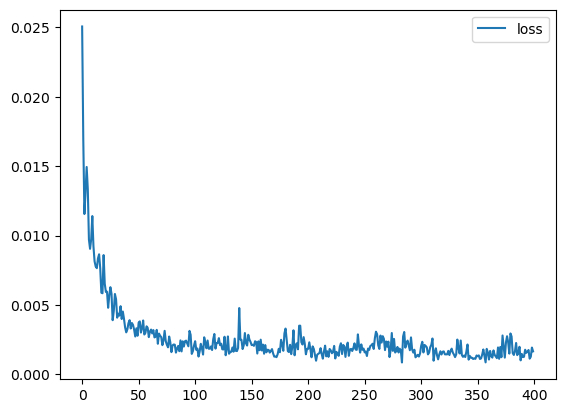

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
losses = [tl.item() for tl in losses]
plt.plot( [t /226 for t in losses ], label = "loss")

plt.legend()
          

In [22]:
test_loss = 0.0
test_score = 0.0
test_loss_list = []
pred_list = []
truth_list = []
label_list = []
score_list = []


In [41]:
from sklearn.metrics import accuracy_score
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, bmi_labels in test_loader:
        # Assuming your model takes images as input
        bmi_out = model(images)
        
        # Assuming bmi_labels is a 1D tensor
        preds = torch.argmax(bmi_out, dim=1).cpu().numpy()
        
        # Collect predictions and labels for computing metrics
        all_preds.extend(preds)
        all_labels.extend(bmi_labels.cpu().numpy())

# Compute accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

   
        
        
        
        
        

ValueError: Classification metrics can't handle a mix of continuous and binary targets

In [ ]:
def train():
    # train_epoch
    # test_epoch
    # luu model/ tra ve model
    # self.best_model = copy.deepcopy(self.model)
    pass


